In [77]:
import polars as pl
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pathlib import Path

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#### Processar arquivos txt e transformar em um dataframe

In [78]:
schema = {
    "index": pl.UInt64,
    "x": pl.Float64,
    "amplitude": pl.Float64,
    "domain": pl.String,
    "run": pl.Int32,
    "type": pl.String,
}
experiment_data = pl.DataFrame(schema=schema)

pathlist = Path("experimento2").rglob("*.txt")

for path in pathlist:
    domain = "time" if "Time" in str(path) else "frequency"
    n_rows = 8192 if domain == "time" else 3201
    run = int(re.findall(r"[nua|mat](\d+)", str(path))[0])
    type = re.findall(r"nua|mat", str(path))[0]
    df = pl.read_csv(
        path,
        has_header=False,
        new_columns=["index", "x", "amplitude"],
        schema=schema,
        separator="\t",
        skip_rows=83,
        n_rows=n_rows,
        ignore_errors=True,
    ).with_columns(
        pl.lit(domain).alias("domain"),
        pl.lit(run).alias("run"),
        pl.lit(type).alias("type"),
    )
    experiment_data = pl.concat([experiment_data, df])

#### Gráficos no domínio do tempo

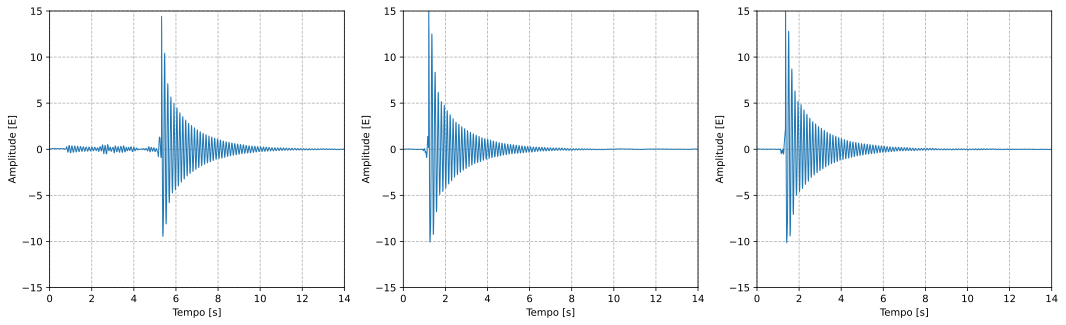

In [79]:
# sem material (chapa nua)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


time_naked_beam = (
    experiment_data.filter((pl.col("type") == "nua") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = time_naked_beam.filter(pl.col("run") == (idx + 1))
    ax.plot(current_run.select("x"), current_run.select("amplitude"), linewidth=1)

    ax.set_xlim((0, 14))
    ax.set_ylim((-15, 15))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

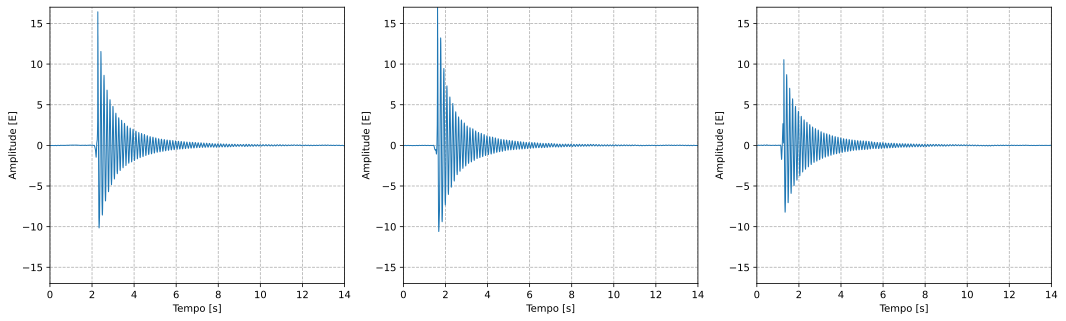

In [80]:
# com material (chapa com absorvedor)
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


time_absorbed_beam = (
    experiment_data.filter((pl.col("type") == "mat") & (pl.col("domain") == "time"))
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = time_absorbed_beam.filter(pl.col("run") == (idx + 1))
    ax.plot(current_run.select("x"), current_run.select("amplitude"), linewidth=1)

    ax.set_xlim((0, 14))
    ax.set_ylim((-17, 17))
    ax.set_xlabel("Tempo [s]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

#### Gráficos no domínio da frequência

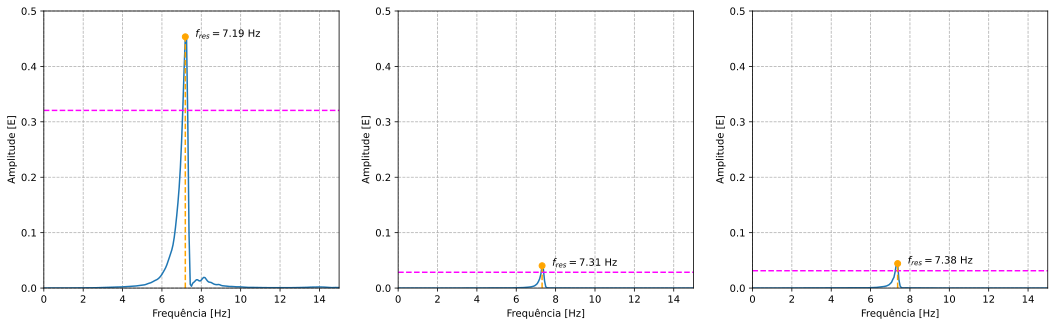

In [81]:
# sem material (chapa nua)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


freq_naked_beam = (
    experiment_data.filter(
        (pl.col("type") == "nua") & (pl.col("domain") == "frequency")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = freq_naked_beam.filter(pl.col("run") == (idx + 1))
    ressonance = current_run.filter(pl.col("amplitude") == pl.col("amplitude").max())

    ax.plot(
        current_run.select("x"), current_run.select("amplitude")
    )  # half-power  band
    ax.annotate(
        rf"$f_{{res}} = {round(ressonance.select('x').item(), 2)}~\text{{Hz}}$",
        (ressonance.select("x").item(), ressonance.select("amplitude").item()),
        (1, 0),
        textcoords="offset fontsize",
    )
    ax.axhline(
        ressonance.select(pl.col("amplitude") / np.sqrt(2)).item(),
        linestyle="--",
        color="magenta",
    )
    markerline, stemlines, baseline = ax.stem(
        ressonance.select("x").to_numpy(),
        ressonance.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 15))
    ax.set_ylim((0, 0.5))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

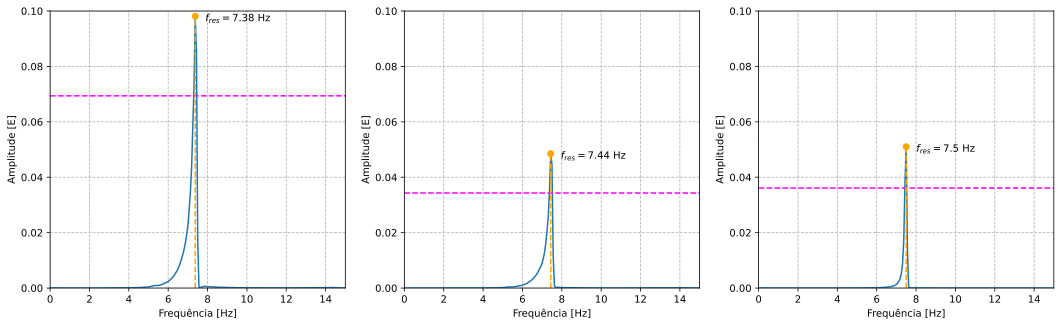

In [82]:
# com material (chapa com absorvedor)

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))


freq_absorbed_beam = (
    experiment_data.filter(
        (pl.col("type") == "mat") & (pl.col("domain") == "frequency")
    )
    .sort(by=["run", "index"])
    .select("x", "amplitude", "run")
)

for idx, ax in enumerate(axs.flat):
    current_run = freq_absorbed_beam.filter(pl.col("run") == (idx + 1))
    ressonance = current_run.filter(pl.col("amplitude") == pl.col("amplitude").max())

    ax.plot(
        current_run.select("x"), current_run.select("amplitude")
    )  # half-power  band
    ax.annotate(
        rf"$f_{{res}} = {round(ressonance.select('x').item(), 2)}~\text{{Hz}}$",
        (ressonance.select("x").item(), ressonance.select("amplitude").item()),
        (1, -0.5),
        textcoords="offset fontsize",
    )
    ax.axhline(
        ressonance.select(pl.col("amplitude") / np.sqrt(2)).item(),
        linestyle="--",
        color="magenta",
    )
    markerline, stemlines, baseline = ax.stem(
        ressonance.select("x").to_numpy(),
        ressonance.select("amplitude").to_numpy(),
        markerfmt="o",
    )
    plt.setp(markerline, "color", "orange")
    plt.setp(stemlines, "linestyle", "--")
    plt.setp(stemlines, "color", "orange")

    ax.set_xlim((0, 15))
    ax.set_ylim((0, 0.1))
    ax.set_xlabel("Frequência [Hz]")
    ax.set_ylabel("Amplitude [E]")
    ax.grid(axis="both", linestyle="--")

plt.show()

#### Fator de amortecimento no domínio do tempo
Será utilizado o decaimento logarítmico entre o 2º e o 12º pico, de forma que
$$ \delta = \frac{1}{10} \ln \frac{A_2}{A_{12}}$$

In [83]:
decays = pl.DataFrame(
    schema={"run": pl.Int64, "type": pl.String, "a2": pl.Float64, "a12": pl.Float64}
)

fig = px.line(time_absorbed_beam.filter(pl.col("run") == 3), x="x", y="amplitude")
fig.show()

# barra nua
decays = pl.concat(
    [decays, pl.DataFrame({"run": [1], "type": ["nua"], "a2": 10.4235, "a12": 2.32424})]
)
decays = pl.concat(
    [decays, pl.DataFrame({"run": [2], "type": ["nua"], "a2": 12.5088, "a12": 2.44153})]
)
decays = pl.concat(
    [decays, pl.DataFrame({"run": [3], "type": ["nua"], "a2": 12.8027, "a12": 2.45808})]
)
# barra com absorvedor
decays = pl.concat(
    [decays, pl.DataFrame({"run": [1], "type": ["mat"], "a2": 11.5483, "a12": 2.12663})]
)
decays = pl.concat(
    [decays, pl.DataFrame({"run": [2], "type": ["mat"], "a2": 13.2202, "a12": 2.1681})]
)
decays = pl.concat(
    [decays, pl.DataFrame({"run": [3], "type": ["mat"], "a2": 8.70044, "a12": 2.05883})]
)

time_domain_damping = decays.with_columns(
    (0.1 * np.log(pl.col("a2") / pl.col("a12"))).alias("decay_rate")
).with_columns(
    (
        pl.col("decay_rate") / np.sqrt(pl.col("decay_rate") ** 2 + (2 * np.pi) ** 2)
    ).alias("damping_factor")
)

time_domain_damping.select("type", "damping_factor").group_by("type").mean()

type,damping_factor
str,f64
"""mat""",0.026204
"""nua""",0.025376


#### Fator de amortecimento no domínio da frequência
Será utilizado a largura de banda de meia potência. A banda de meia potência é definida na posição com amplitude igual a $\frac{Q}{\sqrt{2}}$, onde $Q$ é o valor de pico. Então,
$$ \zeta = \frac{1}{2} \frac{\Delta \omega }{\omega_r}$$

Será necessário fazer uma interpolação para encontrarmos os pontos que tocam na banda de meia potência.

In [84]:
frequencies = pl.DataFrame(
    schema={"run": pl.Int64, "type": pl.String, "w1": pl.Float64, "w2": pl.Float64}
)


# interpolate in a reasonable frequency range
linear_interpolate = (
    pl.DataFrame(np.arange(96.0, 128.01, 0.001), schema={"index": pl.UInt32})
    .join(
        freq_absorbed_beam.filter(pl.col("run") == 3).with_row_index(),
        on="index",
        how="left",
    )
    .with_columns(
        pl.when(pl.col("x").is_first_distinct()).then(pl.col("x", "amplitude", "run"))
    )
    .interpolate()
)

fig = px.scatter(linear_interpolate, x="x", y="amplitude")
fig.add_hline(
    y=(
        freq_absorbed_beam.filter(pl.col("run") == 3).select("amplitude").max()
        / np.sqrt(2)
    ).item()
)
fig.show()


frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [1], "type": ["nua"], "w1": 7.0585, "w2": 7.306}),
    ]
)
frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [2], "type": ["nua"], "w1": 7.264625, "w2": 7.392313}),
    ]
)
frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [3], "type": ["nua"], "w1": 7.256375, "w2": 7.402938}),
    ]
)
frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [1], "type": ["mat"], "w1": 7.297937, "w2": 7.45175}),
    ]
)
frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [2], "type": ["mat"], "w1": 7.370375, "w2": 7.519625}),
    ]
)
frequencies = pl.concat(
    [
        frequencies,
        pl.DataFrame({"run": [3], "type": ["mat"], "w1": 7.432437, "w2": 7.52525}),
    ]
)


ressonances = (
    experiment_data.filter((pl.col("domain") == "frequency"))
    .filter(pl.col("amplitude") == pl.col("amplitude").max().over("type", "run"))
    .select("run", "type", pl.col("x").alias("wr"), "amplitude")
)

freq_domain_damping = frequencies.join(ressonances, on=["run", "type"]).with_columns(
    (0.5 * (pl.col("w2") - pl.col("w1")) / pl.col("wr")).alias("damping_factor")
)


freq_domain_damping.select("type", "damping_factor").group_by("type").mean()

type,damping_factor
str,f64
"""mat""",0.008883
"""nua""",0.011962
